# Collect Data

In [1]:
from coletor import collect_data
import os
from time import sleep
collect_data()
sleep(1)
os.system(r'''taskkill /IM terminal64.exe''')

connected to account #76056949
Tamanho dos dados de WIN@N_M15: 20000
Tamanho dos dados de WIN@N_D1: 1206
Tamanho dos dados de WDO@N_M15: 20000
Tamanho dos dados de WDO@N_D1: 1195
Tamanho dos dados de ITUB4_M15: 20000
Tamanho dos dados de ITUB4_D1: 2431
Tamanho dos dados de BBDC4_M15: 20000
Tamanho dos dados de BBDC4_D1: 2430
Tamanho dos dados de VALE3_M15: 20000
Tamanho dos dados de VALE3_D1: 2499
Tamanho dos dados de PETR4_M15: 20000
Tamanho dos dados de PETR4_D1: 2452
Tamanho dos dados de ABEV3_M15: 20000
Tamanho dos dados de ABEV3_D1: 2439
Tamanho dos dados de BBAS3_M15: 20000
Tamanho dos dados de BBAS3_D1: 2444


0

# Get previsions

In [3]:
import os
# os.system(r'''matlab.exe -nosplash -nodesktop -batch "cd C:\Users\gubar\Documents\UFMG\TCC\; try, run ('C:\Users\gubar\Documents\UFMG\TCC\matlab\main.m'); end; quit"''')
os.system(r'''matlab.exe -r "cd C:\Users\gubar\Documents\UFMG\TCC\; try, run ('C:\Users\gubar\Documents\UFMG\TCC\matlab\main.m'); end;"''')

0

# Run Backtests

In [13]:
from trader import Trader
import pandas as pd
import glob
from backtest import backtest
import multiprocess
import numpy as np
m15_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/data/*M15.csv")
d1_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/previsions/*D1.csv")


def calc_backtest(teste):
    from trader import Trader
    from backtest import backtest
    df_m15, df_d1, m15_file, stop, gain = teste
    trader = Trader(stop, gain)
    df_orders_original, df_orders_summary = backtest(df_m15, df_d1, trader)
    return {
        "stock_code": m15_file.split("/data\\")[1].split("_")[0],
        "df_orders_summary": df_orders_summary,
        "stop": stop, 
        "gain": gain
    }

iterable = []

for index, m15_file in enumerate(m15_files):
    # if m15_file.split("/data\\")[1].split("_")[0] != "WIN":
    #     continue
    df_d1     = pd.read_csv(d1_files[index])
    df_d1.columns = ["time", "min_ann", "max_ann", "real_volume"]

    df_d1['date'] = pd.to_datetime(df_d1['time'],unit='s').dt.date
    df_d1['time'] = pd.to_datetime(df_d1['time'],unit='s')

    df_m15 = pd.read_csv(m15_file)
    df_m15['time'] = pd.to_datetime(df_m15['time'],unit='s')
    iterable.append((df_m15, df_d1, m15_file, 0.35, 0.8))

a_pool = multiprocess.Pool()
dfs_orders_summary = a_pool.map(calc_backtest, iterable)


# Distribuição resultados

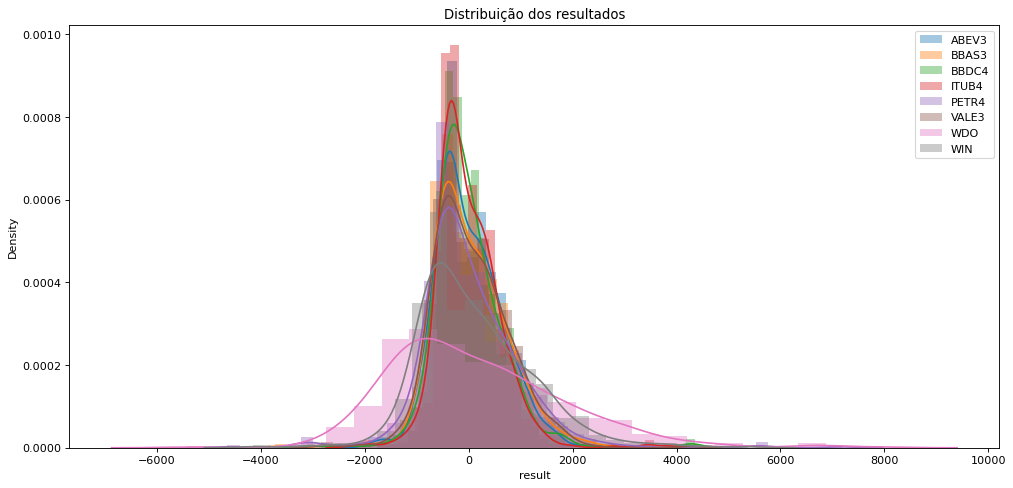

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

plt.figure(figsize=(15,7), dpi= 80)

for item in dfs_orders_summary:

    sns.distplot(item["df_orders_summary"]["result"], label=item["stock_code"])
plt.legend()
plt.title("Distribuição dos resultados")
plt.savefig('../results/save_as_a_png.png')

# Resultado linhas

In [15]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.kaleido.scope.default_width = "1184"
pio.kaleido.scope.default_height = "450"
fig = go.Figure()
for item in dfs_orders_summary:
    fig.add_trace(go.Scatter(x=item["df_orders_summary"]["time"], y=item["df_orders_summary"]["cum_result"],
                        mode='lines',
                        name=item["stock_code"]))
# fig.update_layout(yaxis_range=[0,150000000000e3])
fig.show()
fig.write_image("../results/fig1.png")



# Cálculo Métricas

In [16]:
from metrics import calc_drawdawn, success_rate, annualized_return

metrics_results = []
trader = Trader(0.35, 0.8)
for item in dfs_orders_summary:
    df_orders_summary = item["df_orders_summary"]
    maximum_drawdown, maximum_drawdown_percentage = calc_drawdawn(df_orders_summary)
    rate = success_rate(df_orders_summary)
    annualized = annualized_return(trader.initial_capital, df_orders_summary)
    metrics_results.append({
        "stock_code": item["stock_code"],
        "maximum_drawdown": maximum_drawdown.min(),
        "maximum_drawdown_percentage": maximum_drawdown_percentage.min(),
        "rate": rate,
        "gain": item["gain"],
        "stop": item["stop"],
        "annualized_returns": annualized
    })

In [17]:
pd.DataFrame(metrics_results).sort_values(by=['stock_code', 'annualized_returns'], ascending=False)
df_metrics_results = pd.DataFrame(metrics_results)
df_metrics_results.to_latex("../results/metrics_results.tex")
display(df_metrics_results)

,stock_code,maximum_drawdown,maximum_drawdown_percentage,rate,gain,stop,annualized_returns
0,ABEV3,-16937.54,-29.624156,44.533762,0.8,0.35,-0.371370
1,BBAS3,-12352.10,-24.774957,45.898778,0.8,0.35,10.249118
2,BBDC4,-14626.21,-27.199171,41.852487,0.8,0.35,-5.106144
3,ITUB4,-15046.16,-28.468747,43.654822,0.8,0.35,-2.879834
4,PETR4,-16600.06,-24.730863,42.515924,0.8,0.35,4.831566
5,VALE3,-11413.24,-19.036290,46.880000,0.8,0.35,12.324474
6,WDO,-20550.00,-25.946970,46.833013,0.8,0.35,50.995899
7,WIN,-8580.00,-14.414112,46.666667,0.8,0.35,38.082711


# Contorno do stop gain

In [30]:
from trader import Trader
import pandas as pd
import glob
from backtest import backtest
import multiprocess
import numpy as np
m15_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/data/*M15.csv")
d1_files = glob.glob(r"C:/Users/gubar/Documents/UFMG/TCC/previsions/*D1.csv")


def calc_backtest(teste):
    from trader import Trader
    from backtest import backtest
    df_m15, df_d1, m15_file, stop, gain = teste
    trader = Trader(stop, gain)
    df_orders_original, df_orders_summary = backtest(df_m15, df_d1, trader)
    return {
        "stock_code": m15_file.split("/data\\")[1].split("_")[0],
        "df_orders_summary": df_orders_summary,
        "stop": stop, 
        "gain": gain
    }

iterable = []
stops = [
    (0.45, 0.5),
    (0.15, 0.75),
    (0.2, 0.9),
    (0.2, 0.75),
    (0.15, 0.9)
]
for stop in np.arange(0.1, 0.5, 0.05):
    for gain in np.arange(0.5, 0.95, 0.05):
# for stop, gain in stops:
        for index, m15_file in enumerate(m15_files):
            # if m15_file.split("/data\\")[1].split("_")[0] == "MGLU3":
            #     continue
            if m15_file.split("/data\\")[1].split("_")[0] != "VALE3":
                continue
            df_d1     = pd.read_csv(d1_files[index])
            df_d1.columns = ["time", "min_ann", "max_ann", "real_volume"]

            df_d1['date'] = pd.to_datetime(df_d1['time'],unit='s').dt.date
            df_d1['time'] = pd.to_datetime(df_d1['time'],unit='s')

            df_m15 = pd.read_csv(m15_file)
            df_m15['time'] = pd.to_datetime(df_m15['time'],unit='s')
            iterable.append((df_m15, df_d1, m15_file, stop, gain))

a_pool = multiprocess.Pool()
dfs_orders_summary = a_pool.map(calc_backtest, iterable)



In [31]:
from metrics import calc_drawdawn, success_rate, annualized_return

metrics_results = []
trader = Trader(0.20, 0.60)
for item in dfs_orders_summary:
    df_orders_summary = item["df_orders_summary"]
    maximum_drawdown, maximum_drawdown_percentage = calc_drawdawn(df_orders_summary)
    rate = success_rate(df_orders_summary)
    annualized = annualized_return(trader.initial_capital, df_orders_summary)
    metrics_results.append({
        "stock_code": item["stock_code"],
        "maximum_drawdown": maximum_drawdown.min(),
        "maximum_drawdown_percentage": maximum_drawdown_percentage.min(),
        "rate": rate,
        "gain": item["gain"],
        "stop": item["stop"],
        "annualized_returns": annualized
    })

pd.DataFrame(metrics_results).sort_values(by=['stock_code', 'annualized_returns'], ascending=False)
df_metrics_results = pd.DataFrame(metrics_results)

Text(0.5, 54.16666666666669, 'Take-Profit')

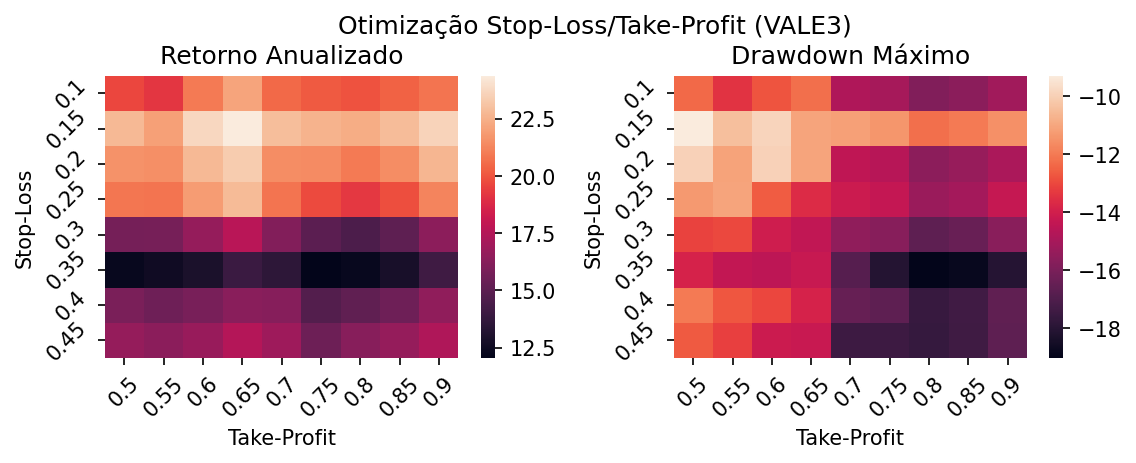

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8,3), dpi=150)
fig.tight_layout(pad=3.0)
fig.suptitle("Otimização Stop-Loss/Take-Profit (VALE3)")

df_metrics_results["gain"] = round(df_metrics_results["gain"], 2)
df_metrics_results["stop"] = round(df_metrics_results["stop"], 2)

df_heatmap = df_metrics_results[df_metrics_results["stock_code"] == "VALE3"][["stop", "gain", "annualized_returns"]]
df_heatmap = df_heatmap.pivot(index='stop', columns='gain', values='annualized_returns')
ax = sns.heatmap(df_heatmap, ax = axes[0])
ax.title.set_text('Retorno Anualizado')
ax.set_ylabel('Stop-Loss')
ax.set_xlabel('Take-Profit')

ax.tick_params(labelrotation=45)


df_heatmap = df_metrics_results[df_metrics_results["stock_code"] == "VALE3"][["stop", "gain", "maximum_drawdown_percentage"]]
df_heatmap = df_heatmap.pivot(index='stop', columns='gain', values='maximum_drawdown_percentage')
ax = sns.heatmap(df_heatmap, ax = axes[1])
ax.title.set_text('Drawdown Máximo')
ax.tick_params(labelrotation=45)
ax.set_ylabel('Stop-Loss')
ax.set_xlabel('Take-Profit')

In [26]:
import seaborn as sns

df_heatmap = df_metrics_results[df_metrics_results["stock_code"] == "PETR4"][["stop", "gain", "annualized_returns"]]
df_heatmap = df_heatmap.pivot(index='stop', columns='gain', values='annualized_returns')

ax = sns.heatmap(df_heatmap)

ValueError: zero-size array to reduction operation fmin which has no identity

# Analyse results

In [ ]:
df_orders_exit_order["cum_result"] = df_orders_exit_order["result"].cumsum()

fig = px.line(df_orders_exit_order, x="time", y=["min_ann", "max_ann", "close", "cum_result"])
fig.show()

In [ ]:
from IPython.core.display import display, HTML

for item in dfs_orders_summary:
    if (item["stock_code"] != "WDO"):
        continue
    df_orders_summary = item["df_orders_summary"]
    display(HTML(df_orders_summary.to_html()))


In [ ]:
dfs_orders_summary[dfs_orders_summary["stock_code"] == "WDO@N"]